In [2]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


import prepare_skyler as p
import explore_skyler as e
import model_skyler as m
from scipy.stats import zscore

### Load dataset + Preprocessing

In [3]:
df = p.get_df()

In [4]:
df['quality_label'] = df.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
df = df.sample(frac=1, random_state=101).reset_index(drop=True)

In [5]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,quality_label
0,6.2,0.30,0.30,2.50,0.041,29.0,82.0,0.99065,3.31,0.61,11.8,7,white,medium
1,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,7,white,medium
2,7.2,0.33,0.28,1.40,0.034,26.0,109.0,0.99246,3.28,0.57,10.6,6,white,medium
3,7.1,0.32,0.24,13.10,0.050,52.0,204.0,0.99800,3.10,0.49,8.8,5,white,low
4,6.0,0.31,0.38,4.80,0.040,41.0,101.0,0.98968,3.24,0.56,13.1,6,white,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,9.4,0.30,0.56,2.80,0.080,6.0,17.0,0.99640,3.15,0.92,11.7,8,red,high
4842,9.4,0.33,0.59,2.80,0.079,9.0,30.0,0.99760,3.12,0.54,12.0,6,red,medium
4843,7.3,0.30,0.42,7.35,0.025,51.0,175.0,0.99280,3.04,0.32,11.4,6,white,medium
4844,7.9,0.29,0.36,11.10,0.033,43.0,208.0,0.99690,3.14,0.46,10.3,5,white,low


In [6]:
df.quality_label.value_counts()

medium    2953
low       1753
high       140
Name: quality_label, dtype: int64

In [7]:
df.dropna().quality_label.value_counts()

medium    2953
low       1753
high       140
Name: quality_label, dtype: int64

In [8]:
df.duplicated().any()

False

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().any()

False

### EDA

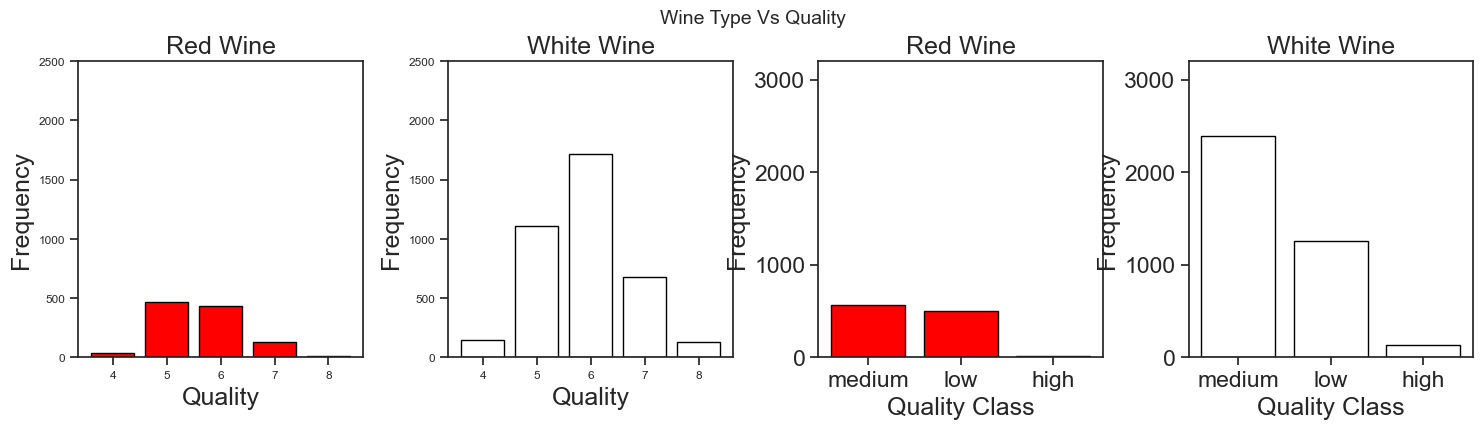

In [10]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = df.quality[df.color == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = df.quality[df.color == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = df.quality_label[df.color == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = df.quality_label[df.color == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

Understanding Wine and Types

Wine is an alcoholic beverage made from grapes which is fermented without the addition of sugars, acids, enzymes, water, or other nutrients

Red wine is made from dark red and black grapes. The color usually ranges from various shades of red, brown and violet. This is produced with whole grapes including the skin which adds to the color and flavor of red wines, giving it a rich flavor.

White wine is made from white grapes with no skins or seeds. The color is usually straw-yellow, yellow-green, or yellow-gold. Most white wines have a light and fruity flavor as compared to richer red wines.

In [13]:
subset_attributes = df.columns
rw = round(df.loc[df.color == 'red', subset_attributes].describe(),2)
ww = round(df.loc[df.color == 'white', subset_attributes].describe(),2)
pd.concat([rw, ww], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1077.0   7.98   1.28  5.00   7.10   7.80   
volatile acidity                  1077.0   0.51   0.15  0.12   0.39   0.52   
citric acid                       1077.0   0.25   0.17  0.00   0.09   0.24   
residual sugar                    1077.0   2.48   1.26  0.90   1.90   2.20   
chlorides                         1077.0   0.08   0.02  0.01   0.07   0.08   
free sulfur dioxide               1077.0  16.20  10.25  1.00   8.00  14.00   
total sulfur dioxide              1077.0  46.84  32.29  6.00  23.00  38.00   
density                           1077.0   1.00   0.00  0.99   1.00   1.00   
pH                                1077.0   3.33   0.13  2.88   3.24   3.33   
sulphates                         1077.0   0.63   0.11  0.37   0.55   0.61   
alcohol                           1077.0  10.44   1.07  8.70   9.50  10.10   
quality                           1077.0   5.65   0.78  4.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          8.90   11.10                3769.0    6.83   0.84   
volatile acidity       0.63    0.84                3769.0    0.28   0.10   
citric acid            0.39    0.73                3769.0    0.33   0.11   
residual sugar         2.60   15.50                3769.0    5.77   4.55   
chlorides              0.09    0.16                3769.0    0.04   0.02   
free sulfur dioxide   22.00   72.00                3769.0   34.14  15.55   
total sulfur dioxide  63.00  278.00                3769.0  135.81  41.79   
density                1.00    1.00                3769.0    0.99   0.00   
pH                     3.41    3.70                3769.0    3.20   0.15   
sulphates              0.70    0.94                3769.0    0.49   0.11   
alcohol               11.20   14.00                3769.0   10.61   1.21   
quality                6.00    8.00                3769.0    5.88   0.86   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.90    6.30    6.80    7.30   10.70  
volatile acidity      0.08    0.21    0.26    0.32    0.82  
citric acid           0.00    0.27    0.32    0.38    0.74  
residual sugar        0.60    1.60    4.70    8.70   18.40  
chlorides             0.01    0.04    0.04    0.05    0.16  
free sulfur dioxide   2.00   23.00   33.00   45.00   83.00  
total sulfur dioxide  9.00  105.00  132.00  164.00  272.00  
density               0.99    0.99    0.99    1.00    1.00  
pH                    2.77    3.10    3.19    3.29    3.70  
sulphates             0.22    0.41    0.47    0.55    0.94  
alcohol               8.40    9.60   10.50   11.40   14.05  
quality               4.00    5.00    6.00    6.00    8.00

In [14]:
# calculate the difference between the two series
diff = rw - ww

# create a new DataFrame from the difference
diff_df = pd.DataFrame(diff)

# display the new DataFrame
diff_df.T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,-2692.0,1.15,0.44,1.10,0.80,1.00,1.60,0.40
volatile acidity,-2692.0,0.23,0.05,0.04,0.18,0.26,0.31,0.02
citric acid,-2692.0,-0.08,0.06,0.00,-0.18,-0.08,0.01,-0.01
residual sugar,-2692.0,-3.29,-3.29,0.30,0.30,-2.50,-6.10,-2.90
chlorides,-2692.0,0.04,0.00,0.00,0.03,0.04,0.04,0.00
free sulfur dioxide,-2692.0,-17.94,-5.30,-1.00,-15.00,-19.00,-23.00,-11.00
total sulfur dioxide,-2692.0,-88.97,-9.50,-3.00,-82.00,-94.00,-101.00,6.00
density,-2692.0,0.01,0.00,0.00,0.01,0.01,0.00,0.00
pH,-2692.0,0.13,-0.02,0.11,0.14,0.14,0.12,0.00
sulphates,-2692.0,0.14,0.00,0.15,0.14,0.14,0.15,0.00


Highlights from descriptive statisct above:

Mean residual sugar and total sulfur dioxide content in white wine seems to be much higher than red wine.

Mean value of sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.

From all numbers, we can observe that citric acid is more present in white than red wines.

In general, white wines has half concentrations of chlorides then red wines.

Although in Ph the difference seems small it is interesting to note that it is slightly larger in green red wines.

In [15]:
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
lw = round(df[df['quality_label'] == 'low'][subset_attributes].describe(),2)
md = round(df[df['quality_label'] == 'medium'][subset_attributes].describe(),2)
hi = round(df[df['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([lw, md, hi], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine'])

fixed acidity  volatile acidity  citric acid  \
Low Quality Wine    count        1753.00           1753.00      1753.00   
                    mean            7.21              0.38         0.30   
                    std             1.06              0.17         0.16   
                    min             4.70              0.10         0.00   
                    25%             6.50              0.26         0.20   
                    50%             7.10              0.33         0.29   
                    75%             7.70              0.49         0.39   
                    max            11.10              0.84         0.74   
Medium Quality Wine count        2953.00           2953.00      2953.00   
                    mean            7.03              0.30         0.32   
                    std             1.07              0.13         0.12   
                    min             4.40              0.08         0.00   
                    25%             6.30              0.21         0.26   
                    50%             6.90              0.27         0.31   
                    75%             7.50              0.36         0.38   
                    max            11.10              0.84         0.74   
High Quality Wine   count         140.00            140.00       140.00   
                    mean            6.78              0.30         0.34   
                    std             1.03              0.11         0.10   
                    min             3.90              0.12         0.03   
                    25%             6.20              0.22         0.29   
                    50%             6.80              0.28         0.32   
                    75%             7.30              0.36         0.37   
                    max            10.70              0.66         0.74   

                           residual sugar  chlorides  free sulfur dioxide  \
Low Quality Wine    count         1753.00    1753.00              1753.00   
                    mean             5.31       0.06                28.72   
                    std              4.57       0.02                17.63   
                    min              0.60       0.01                 2.00   
                    25%              1.80       0.04                14.00   
                    50%              2.80       0.05                26.00   
                    75%              8.00       0.07                41.00   
                    max             18.35       0.16                83.00   
Medium Quality Wine count         2953.00    2953.00              2953.00   
                    mean             4.88       0.05                30.89   
                    std              4.12       0.02                15.59   
                    min              0.70       0.01                 1.00   
                    25%              1.70       0.04                19.00   
                    50%              2.80       0.04                29.00   
                    75%              7.30       0.06                41.00   
                    max             18.40       0.16                83.00   
High Quality Wine   count          140.00     140.00               140.00   
                    mean             4.91       0.04                32.66   
                    std              3.67       0.01                13.62   
                    min              0.80       0.01                 5.00   
                    25%              1.90       0.03                24.00   
                    50%              3.95       0.04                32.50   
                    75%              7.01       0.04                41.00   
                    max             14.80       0.12                70.00   

                           total sulfur dioxide  density       pH  sulphates  \
Low Quality Wine    count               1753.00  1753.00  1753.00    1753.00   
                    mean                 119.31     1.00     3.22

Highlights from descriptive statisct of quality perspective above:

It is interesting how alcohol does not give us much variation to distinguish whether the vine is white or red, but it makes a lot of difference in quality. 

Note that the higher the quality the higher the average alcohol concentration, increased by about 1% at each level. Although lower quality wines have the lowest standard deviation.

The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.

The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.

Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality

### Hypothesis

N1: Mean residual sugar and total sulfur dioxide content in white wine are significantly higher than red wine.

N2: Mean value of sulphates, fixed acidity and volatile acidity are significantly higher in red wine as compared to white wine.

N3: From all numbers, we can observe that citric acid is more present in white than red wines.

N4: In general, white wine has half the concentrations of chlorides of red wines.

N5: Although in Ph the difference seems small it is interesting to note that it is slightly larger in green red wines.


In [16]:
def type_inf_stat_test(feature):
    F, p = f_oneway(df[df.color == 'red'][feature], 
                    df[df.color == 'white'][feature])
    if p <= 0.05:
        msg = 'Reject Null'
    else:
        msg = 'Fail to Reject Null'
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    
def quality_inf_stat_test(feature):
    F, p = f_oneway(df[df.quality_label == 'low'][feature], 
                    df[df.quality_label == 'medium'][feature], 
                    df[df.quality_label == 'high'][feature])
    if p <= 0.05:
        msg = 'Reject Null'
    else:
        msg = 'Fail to Reject Null'
    print('F Statistic: {:.2f} \tp-value: {:.8f} \tNull Hypothesis: {}'.format(F, p, msg))

In [17]:
print('ANOVA test across wine samples with different types:\n')
# - Mean residual sugar and total sulfur dioxide content in white wine seems to be much higher than red wine.
type_inf_stat_test('residual sugar')
type_inf_stat_test('total sulfur dioxide')
#- Mean value of sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.
type_inf_stat_test('sulphates')
type_inf_stat_test('fixed acidity')
type_inf_stat_test('volatile acidity')
#- From all numbers, we can observe that citric acid is more present in white than red wines.
type_inf_stat_test('citric acid')
#- In general, white wines has half concentrations of chlorides then red wines.
type_inf_stat_test('chlorides')
#- Although in Ph the difference seems small it is interesting to note that it is slightly larger in green red wines.
type_inf_stat_test('pH')

ANOVA test across wine samples with different types:

F Statistic: 550.04 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 4170.42 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 1377.24 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 1209.46 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 3552.15 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 362.62 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 4177.91 	p-value: 0.000 	Null Hypothesis: Reject Null
F Statistic: 701.65 	p-value: 0.000 	Null Hypothesis: Reject Null


N1: Alcohol makes a lot of difference in quality. Although lower quality wines have the lowest standard deviation.


N2: The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.

N3: The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.

N4: Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality

In [18]:
print('ANOVA test across wine samples with different levels of quality:\n')
#- alcohol makes a lot of difference in quality. Although lower quality wines have the lowest standard deviation.
quality_inf_stat_test('alcohol')
#- The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.
quality_inf_stat_test('chlorides')
quality_inf_stat_test('volatile acidity')
#- The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.
quality_inf_stat_test('free sulfur dioxide')
#- Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality
quality_inf_stat_test('fixed acidity')

ANOVA test across wine samples with different levels of quality:

F Statistic: 585.84 	p-value: 0.00000000 	Null Hypothesis: Reject Null
F Statistic: 153.87 	p-value: 0.00000000 	Null Hypothesis: Reject Null
F Statistic: 172.10 	p-value: 0.00000000 	Null Hypothesis: Reject Null
F Statistic: 11.46 	p-value: 0.00001087 	Null Hypothesis: Reject Null
F Statistic: 21.54 	p-value: 0.00000000 	Null Hypothesis: Reject Null


In [22]:
# re-shuffle records just to randomize data points
df_wine = df.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(df.color.values) # 1 - White; 0 - Red
df['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = df.quality_label.map(class_ql)

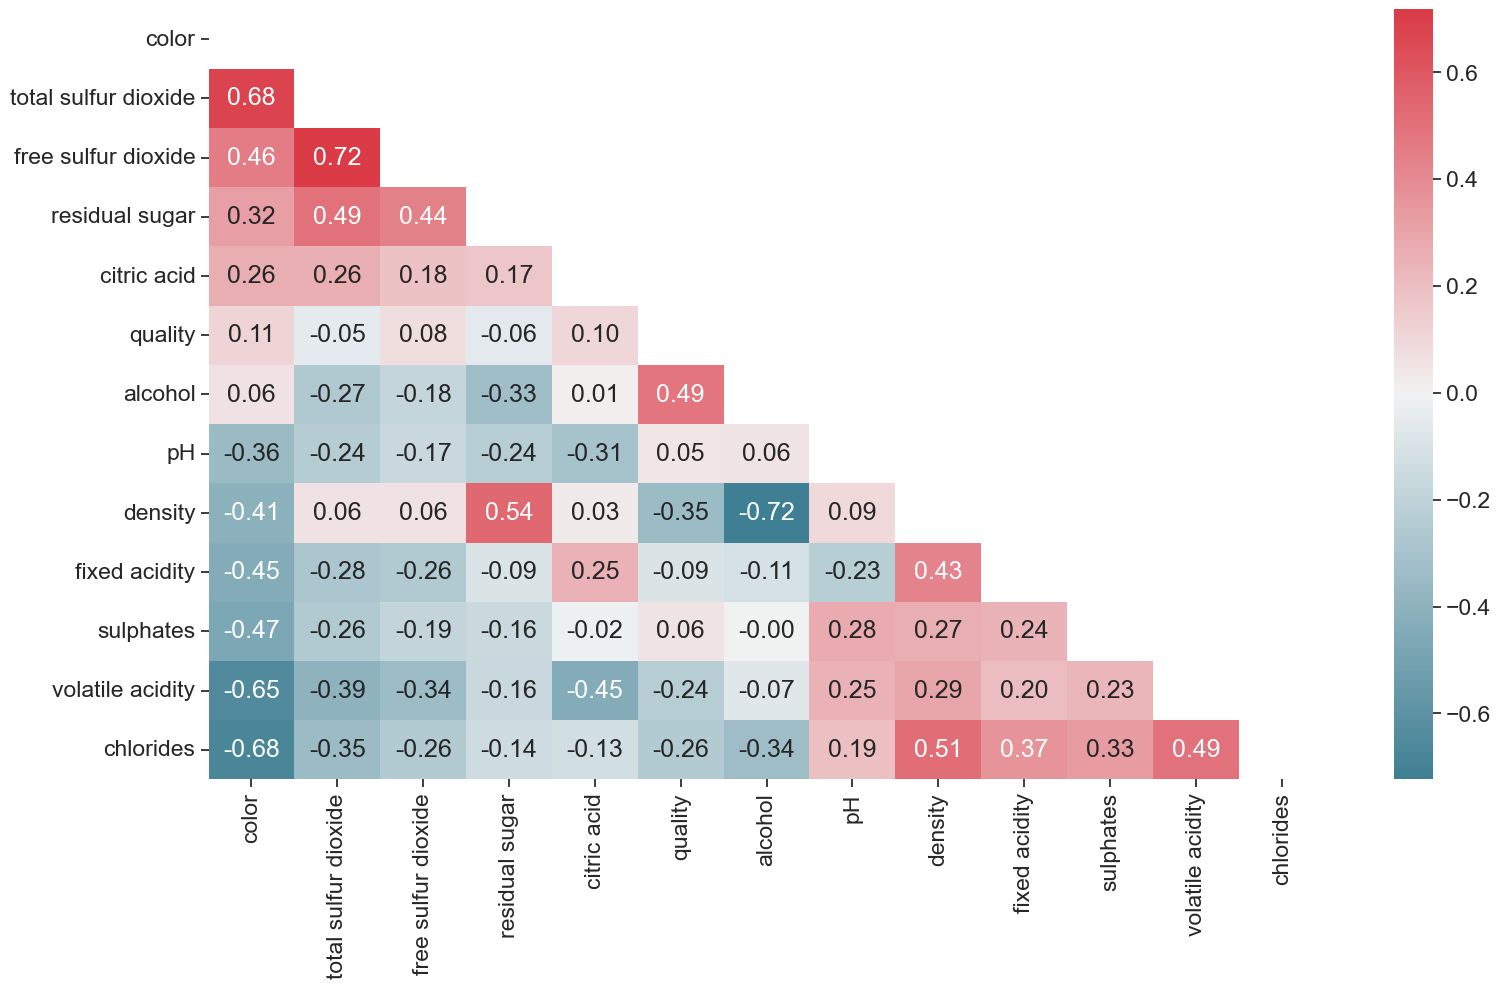

In [23]:
corr = df_wine.corr()
top_corr_cols = corr.color.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)
plt.show()
del corr, dropSelf, top_corr

Text(148.65625, 0.5, 'Variables')

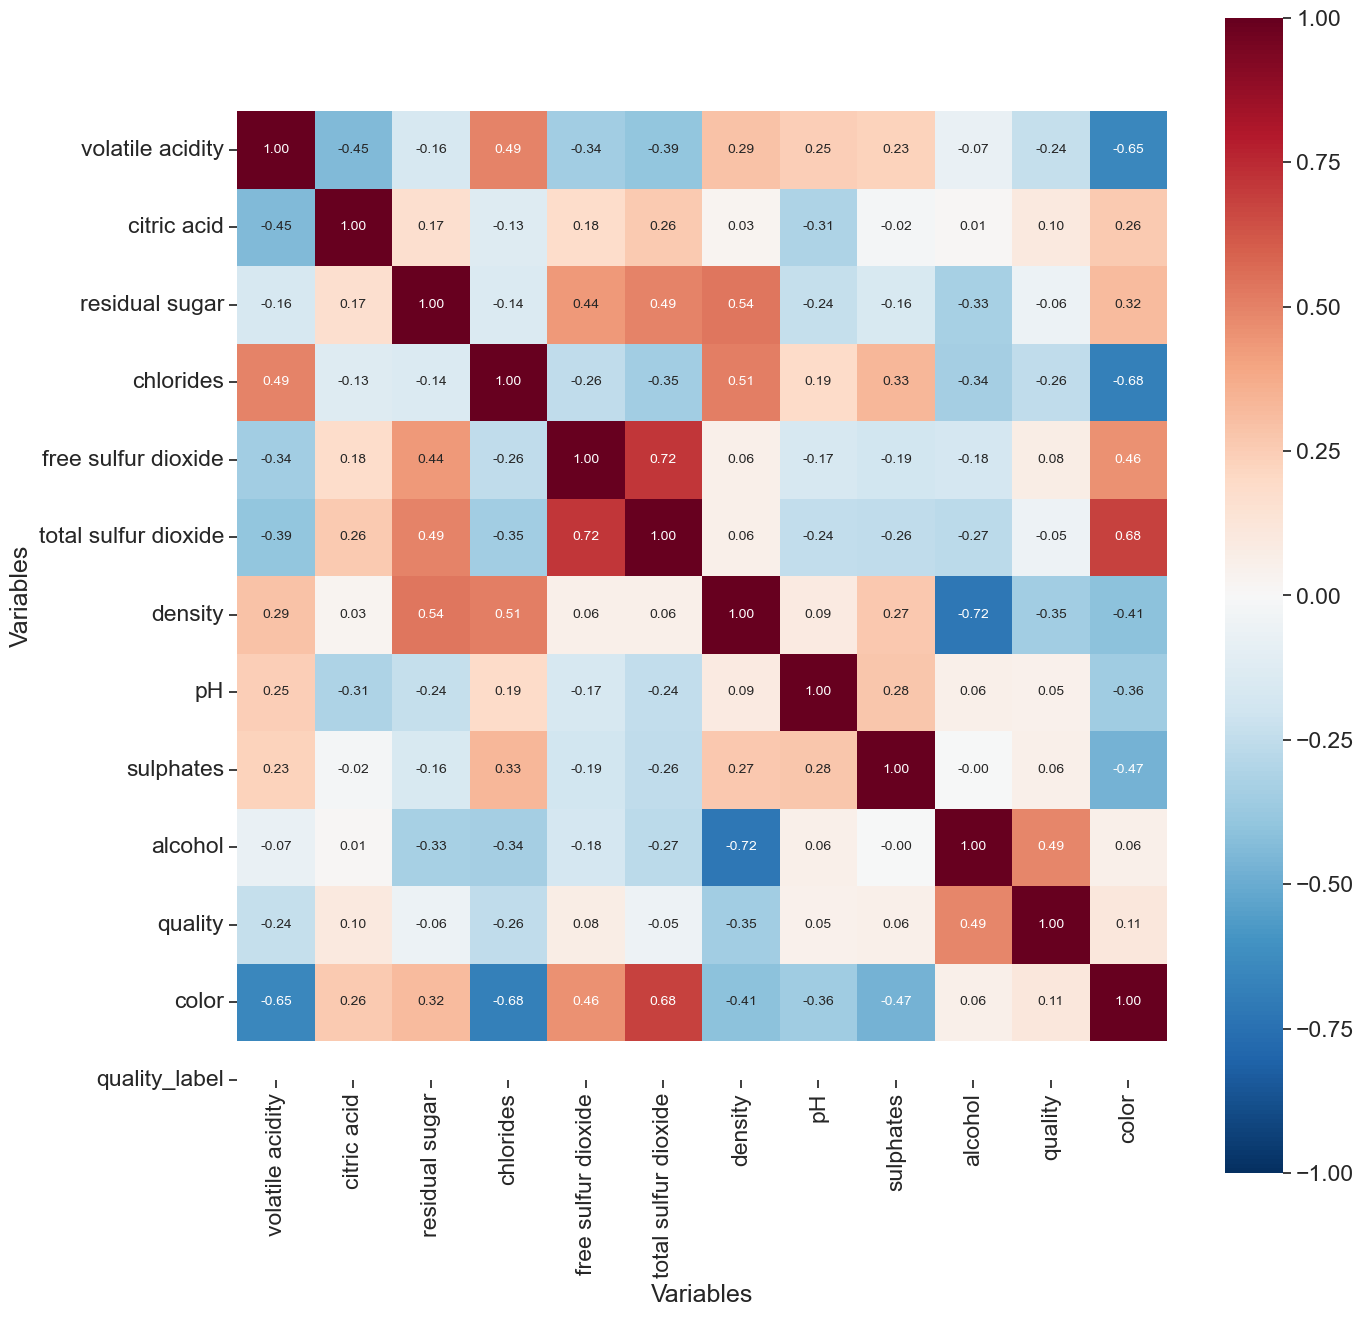

In [21]:
corr_values = df.iloc[:,1:]

# Heatmap
plt.figure(figsize=(15,15))
hm = sns.heatmap(corr_values.corr(),
                cbar=True,
                annot=True,
                square=True,
                cmap="RdBu_r",
                fmt=".2f",
                annot_kws={"size":10},
                yticklabels=corr_values.columns,
                vmax=1,
                vmin=-1,
                center=0)
plt.xlabel("Variables")
plt.ylabel("Variables")

NameError: name 'wines' is not defined

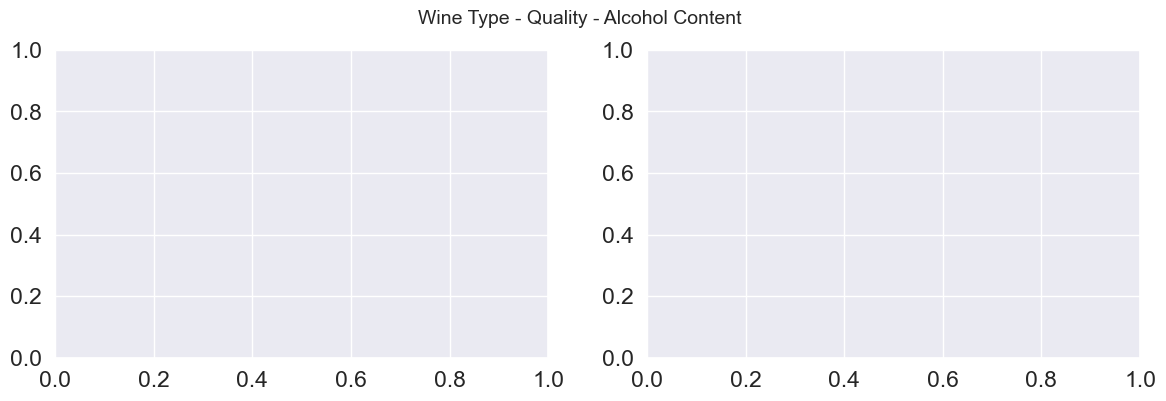

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Alcohol Content', fontsize=14)

sns.boxplot(x='quality', y='alcohol', hue='color', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x='quality_label', y='alcohol', hue='color', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)
plt.show()

In [11]:
g = sns.FacetGrid(wines, col='color', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, 'volatile acidity', 'alcohol', alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(wines, col='color', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile acidity", "total sulfur dioxide", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

NameError: name 'wines' is not defined

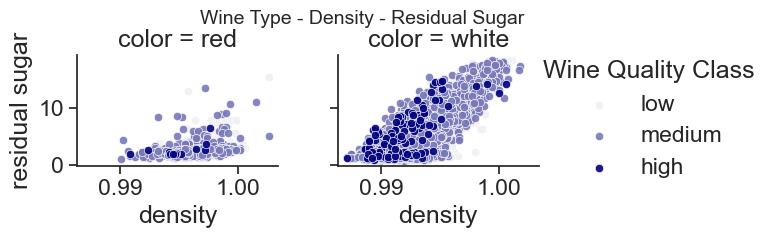

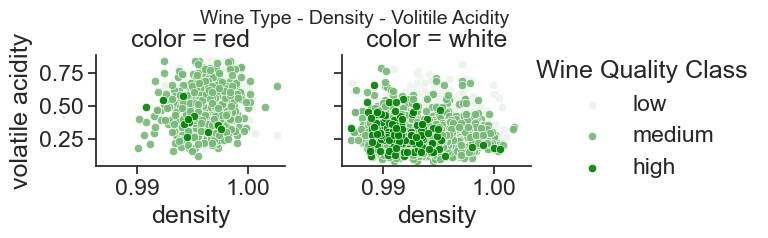

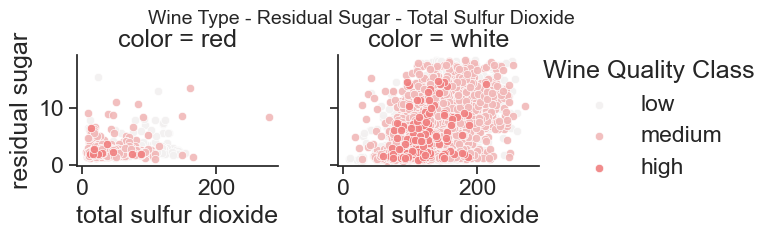

In [15]:
g = sns.FacetGrid(df, col='color', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=2.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, 'density', 'residual sugar', alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Density - Residual Sugar', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(df, col='color', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=2.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "density", "volatile acidity", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Density - Volitile Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(df, col='color', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=2.5, palette=sns.light_palette('lightcoral', 3))
g.map(plt.scatter, "total sulfur dioxide", "residual sugar", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Residual Sugar - Total Sulfur Dioxide', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

In [27]:
# Define a dictionary that maps the quality levels to numerical values
quality_map = {'low': 0, 'medium': 1, 'high': 2}

# Create a new column in the DataFrame that maps the quality values to numerical values
df['quality_num'] = df_wine['quality_label'].map(quality_map)

In [ ]:
df = df.drop(columns='quality_label')

In [ ]:
df

In [ ]:
import plotly as py
import plotly.graph_objs as go

data = df

trace1 = go.Scatter3d(
    x= data['fixed acidity'],
    y= data['quality_num'],
    z= data['volatile acidity'],
    mode='markers',
     marker=dict(
        color = data['volatile acidity'], 
        size= 10,
        line=dict(
            color= data['volatile acidity'],
            width= 12
        ),
        opacity=0.8
     )
)
data1 = [trace1]
layout = go.Layout(
    title= 'Clusters with Fixed Acidity and Volatile Acidity',
    scene = dict(
            xaxis = dict(title  = 'Fixed Acidity'),
            yaxis = dict(title  = 'Quality'),
            zaxis = dict(title  = 'Volatile Acidity')
        )
)
fig = go.Figure(data=data1, layout=layout)
py.offline.iplot(fig)

In [ ]:
import plotly as py
import plotly.graph_objs as go

data = df

trace1 = go.Scatter3d(
    x= data['citric acid'],
    y= data['quality_num'],
    z= data['residual sugar'],
    mode='markers',
     marker=dict(
        color = data['residual sugar'], 
        size= 10,
        line=dict(
            color= data['residual sugar'],
            width= 12
        ),
        opacity=0.8
     )
)
data1 = [trace1]
layout = go.Layout(
    title= 'Clusters with Citric Acid and Residual Sugar',
    scene = dict(
            xaxis = dict(title  = 'Citric Acid'),
            yaxis = dict(title  = 'Quality'),
            zaxis = dict(title  = 'Residual Sugar')
        )
)
fig = go.Figure(data=data1, layout=layout)
py.offline.iplot(fig)

In [ ]:
import plotly as py
import plotly.graph_objs as go

data = df

trace1 = go.Scatter3d(
    x= data['free sulfur dioxide'],
    y= data['quality_num'],
    z= data['chlorides'],
    mode='markers',
     marker=dict(
        color = data['chlorides'], 
        size= 10,
        line=dict(
            color= data['chlorides'],
            width= 12
        ),
        opacity=0.8
     )
)
data1 = [trace1]
layout = go.Layout(
    title= 'Clusters with Free Sulfur Dioxide and Chlorides',
    scene = dict(
            xaxis = dict(title  = 'free sulfur dioxide'),
            yaxis = dict(title  = 'Quality'),
            zaxis = dict(title  = 'chlorides')
        )
)
fig = go.Figure(data=data1, layout=layout)
py.offline.iplot(fig)

In [ ]:
from scipy.stats import skew

wine_df = df

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

# for feature in numerical:
#   sns.boxplot(data = wine_df, y = feature)


fig, axes = plt.subplots(3, 4, figsize=(20,20))

# for i , row in enumerate(axes):
#   i, j = divmod(0, 3)

#   sns.boxplot(data = wine_df, y = features[i], x = 'type', ax = axes[i, j])


for i, ax in enumerate(axes.flat):
    sns.violinplot(data = wine_df, y = features[i], x = 'type', ax = ax)

    sk = skew(wine_df[features[i]])

    print("Feature {} has skewness {}".format(features[i], sk))

# Modeling
## KMeans

In [ ]:
df.head()

In [ ]:
df_dropped = df.drop(columns=['quality_label', 'type'])

In [ ]:
df_dropped

In [ ]:
df_scaled=df_dropped.apply(zscore)
df_scaled.head()

In [ ]:
model=KMeans(n_clusters=3)

In [ ]:
cluster_range=range(1,15)
cluster_error=[]
for a in cluster_range:
    cluster=KMeans(a,n_init=10)
    cluster.fit(df_scaled)
    cluster_error.append(cluster.inertia_)
cluster_df=pd.DataFrame({'num_cluster':cluster_range,'cluster_error':cluster_error})
cluster_df

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(cluster_df['num_cluster'],cluster_df['cluster_error'],marker='o')

In [ ]:
kmeans=KMeans(n_clusters=7,n_init=15,random_state=3)

In [ ]:
kmeans.fit(df_scaled)

In [ ]:
centroids=kmeans.cluster_centers_
pd.DataFrame(centroids,columns=df_scaled.columns)

In [ ]:
df_scaled['class']=kmeans.labels_.astype('object')

In [ ]:
df_scaled.head()

In [ ]:
df_k=df_scaled

In [ ]:
df_k['class']=df_k['class'].astype('object')

In [ ]:
df_k

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=100)
kmeans.fit(df_scaled)
labels = kmeans.labels_
ax.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], df_scaled.iloc[:, 3],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

In [ ]:
df_k['class'].value_counts()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hie_clus = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster2 = hie_clus.fit_predict(df_scaled)

df_h = df_scaled.copy(deep=True)
df_h['class'] = cluster2

In [ ]:
df_h

In [ ]:
df_h['class']=df_h['class'].astype('object')

In [ ]:
print('Original Data Classes:')
print(df['quality'].value_counts())
print('-' * 30)
print('K-Means Predicted Data Classes:')
print(df_k['class'].value_counts())
print('-' * 30)
print('Hierarchical Predicted Data Classes:')
print(df_h['class'].value_counts())

# Classification

In [ ]:
df_k['class'].value_counts()

In [ ]:
x= df_k.drop('class',axis=1)
y= pd.DataFrame(df_k['class'].astype('float64'))

In [ ]:
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=test_size, random_state=seed)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into a 60:20:20 train-validate-test split
train_val_size = 0.8
test_size = 0.2
seed = 7

# Split the data into a train-validation set and a test set
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

# Split the train-validation set into a train set and a validation set
x_train, x_validate, y_train, y_validate = train_test_split(x_train_val, y_train_val, test_size=1 - train_val_size, random_state=seed)


In [ ]:
from sklearn.preprocessing import StandardScaler
independent_scalar = StandardScaler()
x_train = independent_scalar.fit_transform (x_train) #fit and transform
x_validate = independent_scalar.transform (x_validate) # only transform
x_test = independent_scalar.transform (x_test) # only transform

In [ ]:
y.info()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
#DecisionTreeClassifier is the corresponding Classifier
Dtree = DecisionTreeClassifier(max_depth=3)
Dtree.fit(x_train, y_train)

In [ ]:
predictValues_train = Dtree.predict(x_train)
#print(predictValues_train)
accuracy_train=accuracy_score(y_train, predictValues_train)

predictValues_validate = Dtree.predict(x_validate)
#print(predictValues_validate)
accuracy_validate=accuracy_score(y_validate, predictValues_validate)

print("Train Accuracy  :: ",accuracy_train)
print("Validation Accuracy  :: ",accuracy_validate)

In [ ]:
# Evaluate the model on the training set
predictValues_train = Dtree.predict(x_train)
accuracy_train = accuracy_score(y_train, predictValues_train)
print("Train Accuracy  :: ", accuracy_train)

# Evaluate the model on the validation set
predictValues_validate = Dtree.predict(x_validate)
accuracy_validate = accuracy_score(y_validate, predictValues_validate)
print("Validation Accuracy  :: ", accuracy_validate)

# Evaluate the model on the test set
predictValues_test = Dtree.predict(x_test)
accuracy_test = accuracy_score(y_test, predictValues_test)
print("Test Accuracy  :: ", accuracy_test)

In [ ]:
print('Classification Report')
print(classification_report(y_validate, predictValues_validate))

## Random Forest

In [ ]:
RFclassifier = RandomForestClassifier(n_estimators = 100, random_state = 0,min_samples_split=5,criterion='gini',max_depth=5)
RFclassifier.fit(x_train, y_train)

In [ ]:
predictValues_validate = RFclassifier.predict(x_validate)
#print(predictValues_validate)
accuracy_validate=accuracy_score(y_validate, predictValues_validate)



predictValues_train = RFclassifier.predict(x_train)
#print(predictValues_train)
accuracy_train=accuracy_score(y_train, predictValues_train)


print("Train Accuracy  :: ",accuracy_train)
print("Validation Accuracy  :: ",accuracy_validate)

In [ ]:
RFclassifier = RandomForestClassifier(n_estimators = 11, random_state = 0,min_samples_split=5,criterion='gini',max_depth=5)
RFclassifier.fit(x_train, y_train)

In [ ]:
print('Classification Report')
print(classification_report(y_validate, predictValues_validate))

## KNN

In [ ]:
KNN = KNeighborsClassifier(n_neighbors= 8 , weights = 'uniform', metric='euclidean')
KNN.fit(x_train, y_train)

In [ ]:
predictValues_train = KNN.predict(x_train)
print(predictValues_train)
accuracy_train=accuracy_score(y_train, predictValues_train)
print("Train Accuracy  :: ",accuracy_train)

In [ ]:
predictValues_validate = KNN.predict(x_validate)
print(predictValues_validate)
accuracy_validate=accuracy_score(y_validate, predictValues_validate)
print("Validation Accuracy  :: ",accuracy_validate)

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(256, 256), max_iter=500)

model.fit(x_train, y_train)

In [ ]:
print(f'Model Accuracy: {model.score(x_test, y_test)}')